## Short term prediction for beaches affluences

This model can predict affluences up to a single hour in the future.

## Imports

In [206]:
from matplotlib.pyplot import figure, show
from multiprocessing import Pool
from sklearn import cross_validation
from sklearn import metrics
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import datetime
import dateutil.parser
import json
import math
import matplotlib.dates as mdates
import os
import pandas as pd
import pylab as plt
import pytz
import scipy
import sys
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

## Loading datas

Load all datas from the `../data/` directory.

In [207]:
def json_from_file(relative_path):
    with open(relative_path) as fs:
        return json.load(fs)

weather = json_from_file('../data/weather.json')
tides = json_from_file('../data/tides.json')
places = json_from_file("../data/sensors/all_places_infos.json")

roads = pd.read_json("../data/scrappers/ordered.json")
roads['date'] = roads.apply(lambda row: str(row['date'] - datetime.timedelta(minutes = row['date'].minute % 30)), axis = 1)
roads = roads.groupby('date').max()

## Initializing vars

You can change the `up_to` variable to change the number of days from now we'll need weather (if the first measure is one year in the past, you have to set `up_to` to 365).

In [208]:
up_to = 100

allsensors = []
base = datetime.datetime.today()
week_day = {"Mon": 0,
        "Tue": 1,
        "Wed": 2,
        "Thu": 3,
        "Fri": 4,
        "Sat": 5,
        "Sun": 6}

paris = pytz.timezone('Europe/Paris')
utc = pytz.utc

date_list = {}
for x in range(0, up_to):
    date_list[(base - datetime.timedelta(days = x)).strftime("%Y-%m-%d")] = []
    
try:
    os.stat("data")
except:
    os.mkdir("data")

## Useful functions

In [209]:
def retrieve_hour(measure):
    date = dateutil.parser.parse(measure["date"])
    date = date - datetime.timedelta(minutes = date.minute % 30, seconds = date.second, microseconds = date.microsecond)
    return date

def retrieve_nb_measured(measure):
    try:
        return len(measure["value"])
    except:
        return measure["value"]

def get_level(median, nb):
    if (nb <= median):
        return (0)
    if (nb <= 2 * median):
        return (1)
    return (2)

def get_weather(date, hour, what):
    try:
        return weather[str(date.year)][str(date.month)][str(date.day)][what][str(hour)]
    except:
        return 0

def get_prev(df, date, nb_hours):
    date = date - datetime.timedelta(hours = nb_hours)
    if (date in df.index):
        return df.loc[date]["Nb_measured"]
    return 0

def get_roads_affluence(row):
    try:
        date = str(row.name - datetime.timedelta(hours = 1, minutes = 0))
        date = date[:10] + ' ' + date[11:19]
        val = roads.affluence[date]
        return val
    except:
        return 0

def set_shift(row):
    dt = row["Date"] - datetime.timedelta(minutes = row["Date"].minute % 30)
    return dt.strftime("%Y%M%d%H%m")

## Processing data

Process data for each sensor in order to have a better learning set.

In [235]:
data = pd.DataFrame()
for sensor in places:
    measures = json_from_file("../data/sensors/sensor-" + str(sensor["id"]) + "_wifi.json")
    
    print "Processing sensor: \"" + sensor["name"].encode("utf-8") + "\"..."
    if (len(measures) < 150):
        print "  No measures acquired, aborting process."
        continue

    df = pd.DataFrame(data = list(zip(map(retrieve_hour, measures), map(retrieve_nb_measured, measures))), columns = ["Date", "Nb_measured"])

    df["Day"]                 = df.apply(lambda row: row["Date"].date(), axis = 1)
    days_df = df.groupby("Day").max()
    days_df = days_df[days_df["Nb_measured"] < 50]
    for i in days_df.index:
        df = df[df["Day"] != i]
    del df["Day"]

    # Grouping duplicates:
    df = df.groupby("Date").mean()

    # Adding features
    df["Roads"]               = df.apply(lambda row: get_roads_affluence(row), axis = 1)
    df["Day_of_week"]         = df.apply(lambda row: week_day[row.name.strftime("%a")], axis = 1)
    df["Hour_of_day"]         = df.apply(lambda row: row.name.hour, axis = 1)
    df["Weather_Temperature"] = df.apply(lambda row: get_weather(row.name, row.name.hour, "temperature"), axis = 1)
    df["Level"]               = df.apply(lambda row: (get_level(100, row["Nb_measured"])), axis = 1)
    df["Month"]               = df.apply(lambda row: row.name.month, axis = 1)
    df["Weather"]             = df.apply(lambda row: get_weather(row.name, row.name.hour, "weather"), axis = 1)
    df["Weather_Humidity"]    = df.apply(lambda row: get_weather(row.name, row.name.hour, "humidity"), axis = 1)
    df["Weather_Quality"]     = df.apply(lambda row: get_weather(row.name, row.name.hour, "weather_quality"), axis = 1)
    df["Weather_Type"]        = df.apply(lambda row: get_weather(row.name, row.name.hour, "weather_type"), axis = 1)
    df["Tide"]                = df.apply(lambda row: tides[str(row.name.year)][str(row.name.month)][str(row.name.day)][str(row.name.hour)][int(row.name.minute / 15)], axis = 1)
    #df["Nb_measured"]         = df.apply(lambda row: row["Nb_measured"] // 5, axis = 1)
    
    df["id"]                  = sensor["sensor_ids"][0]
    data = data.append(df)

data.to_csv("data/dataset_sensors.csv")

Processing sensor: "Le grand Crohot"...
Processing sensor: "Le Porge"...
Processing sensor: "Carcans (plage centrale)"...
Processing sensor: "Bombannes"...
Processing sensor: "HQ"...
  No measures acquired, aborting process.
Processing sensor: "Lacanau SuperSud"...


------------

# Learning part

You can start process over here if you already saved data from the previous lines.

This script will test the efficiency of the model an print a graph with the predictions and the real measures overlapping to have a look at the efficacity.

## Init


In [236]:
try:
    places
except:
    places = json_from_file("../data/sensors/all_places_infos.json")

clf           = DecisionTreeRegressor(max_depth = 25)

plt.rcParams["figure.figsize"] = (16, 9)

## Collecting data

In [237]:
df = pd.read_csv("data/dataset_sensors.csv", index_col = "Date", parse_dates = True)
    
NB_days = 8
today = datetime.datetime.today()
limit = today - datetime.timedelta(days = NB_days)
tenth_june = datetime.datetime(2010, 6, 15, 0, 0)

learning = df[df.index < limit]
Y = learning[learning.index > tenth_june]["Nb_measured"]
future_Y = df[df.index > limit]["Nb_measured"]

del df["Level"]
del df["Nb_measured"]

X = df[df.index < limit]
X = X[X.index > tenth_june]
future_X = df[df.index > limit]


## Evaluation

This part will output the root of the MSE (square root of the Mean Squared Error) from the cross validation algorithm.

In [238]:
cv = cross_validation.ShuffleSplit(X.shape[0], test_size = 0.2, random_state = 0, n_iter = 100)
scores = cross_validation.cross_val_score(clf, X, Y, scoring = "mean_squared_error", cv = cv)
print("   Mean error of %0.2f (+/- %0.2f)" % (math.sqrt(-scores.mean()), math.sqrt(scores.std() if scores.std() >= 0 else -scores.std())))

   Mean error of 53.78 (+/- 23.18)


## Feature importance

This part is supposed to output the features importance of the tree from all the features given in the aggregating part ("**Processing data**'s subpart).

In [239]:
clf.fit(X, Y)

predicted = pd.Series(clf.predict(future_X), index = future_X.index)
learned = pd.Series(clf.predict(X), index = X.index)
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr

rmse = sqrt(mean_squared_error(future_Y, predicted))
pearson = pearsonr(future_Y, predicted)
print 'RMSE : ', rmse
print 'PEAR : ', pearson[0]
print
print "Features importance: "
for i, feature in enumerate(X.columns):
    print "   " + feature + ": " + str(clf.feature_importances_[i])




RMSE :  132.397649198
PEAR :  0.677869398503

Features importance: 
   Roads: 0.0
   Day_of_week: 0.0847968570814
   Hour_of_day: 0.387354418945
   Weather_Temperature: 0.105213535378
   Month: 0.0815991795114
   Weather: 2.67766127285e-06
   Weather_Humidity: 0.115681241775
   Weather_Quality: 1.98740979838e-07
   Weather_Type: 0.0
   Tide: 0.0611934583852
   id: 0.164158432522


## Graph

We have two figures by sensor:

### First figure

In green, we have the test curve. Measures under the green curve wasn't used to fit the model.
In purple, we have the learning curve; measures under it were the measures used to fit.

### Second figure

It's a "monitoring" figure which allow to see differences between prediction and real measures.
If it's negative, it means we predicted less affluence than observations.
If it's positive, it means we predicted more affluence than observed.

The value of the differences is took with a margin of +/- 10 minutes, so if we predicted 200 persons when we have 10 persons, and then, ten minutes later, we have 200 persons, the difference is 0.

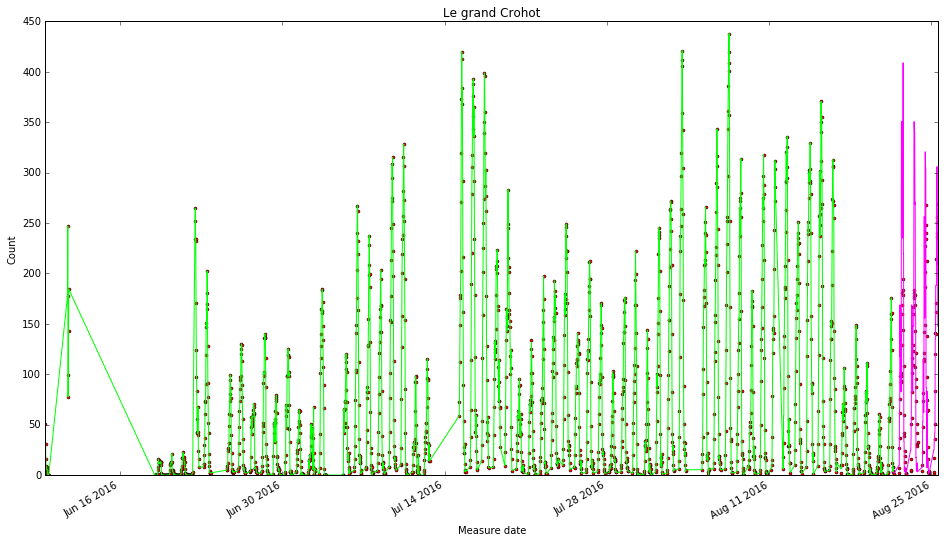

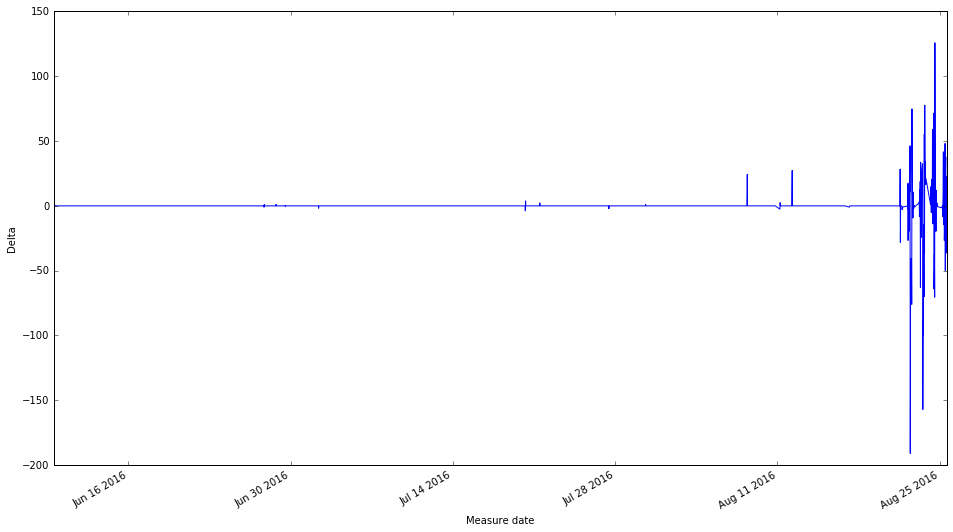

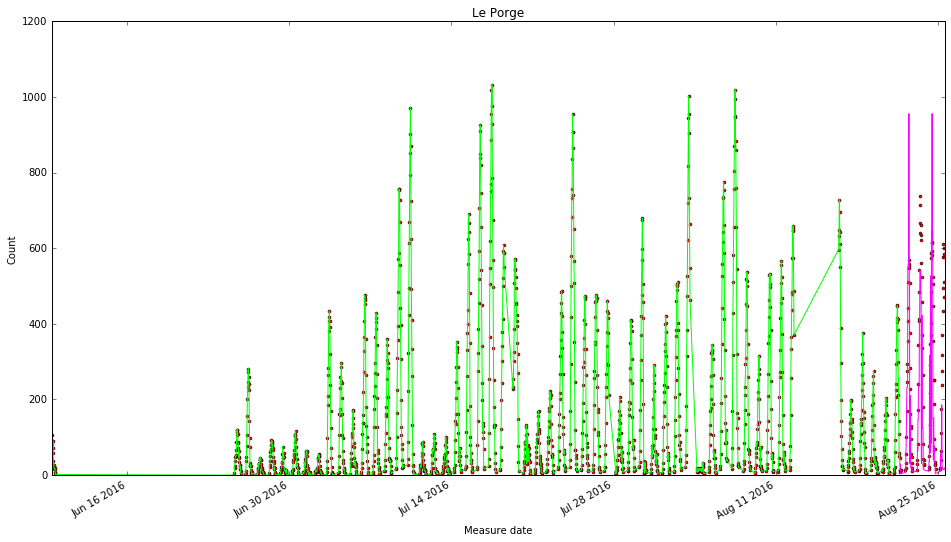

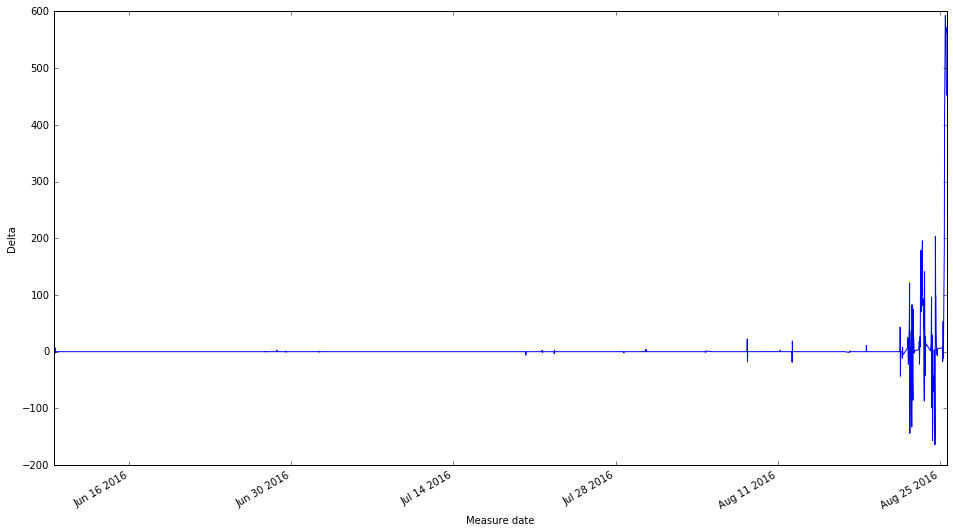

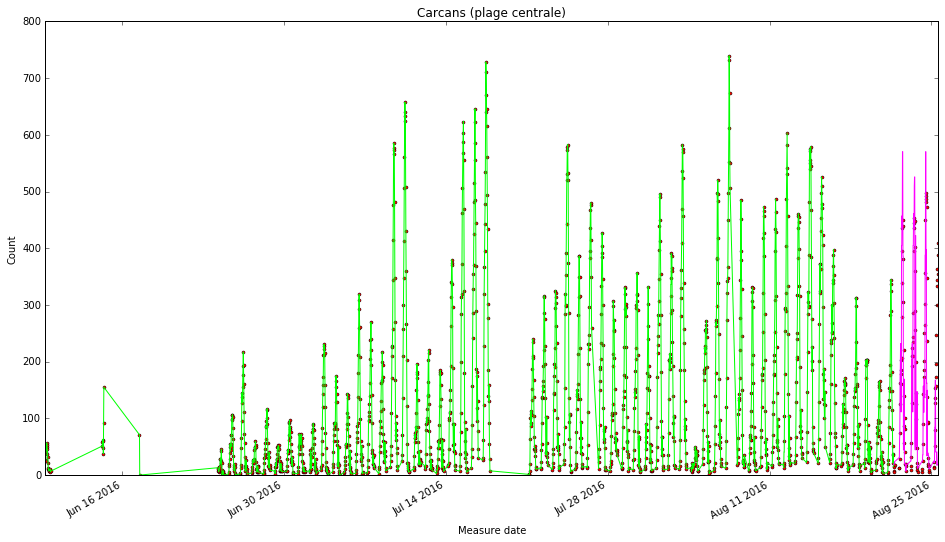

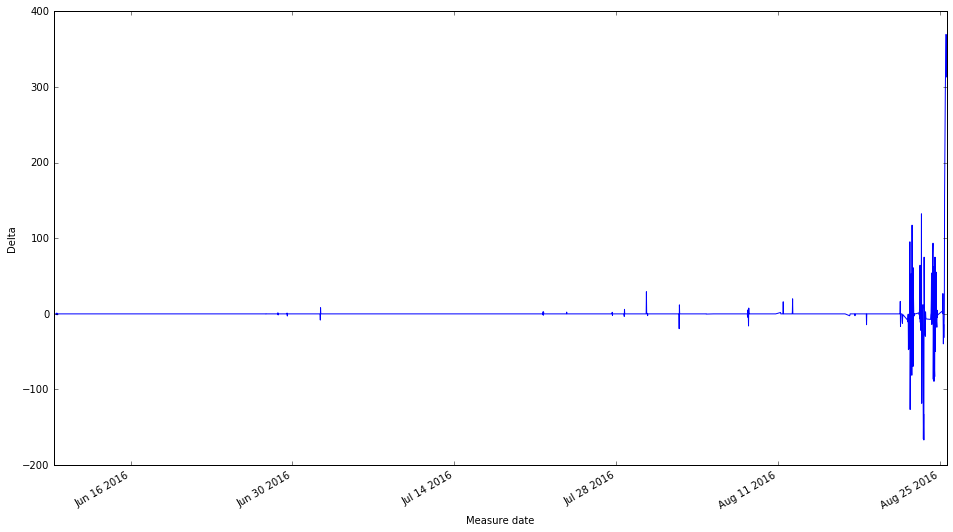

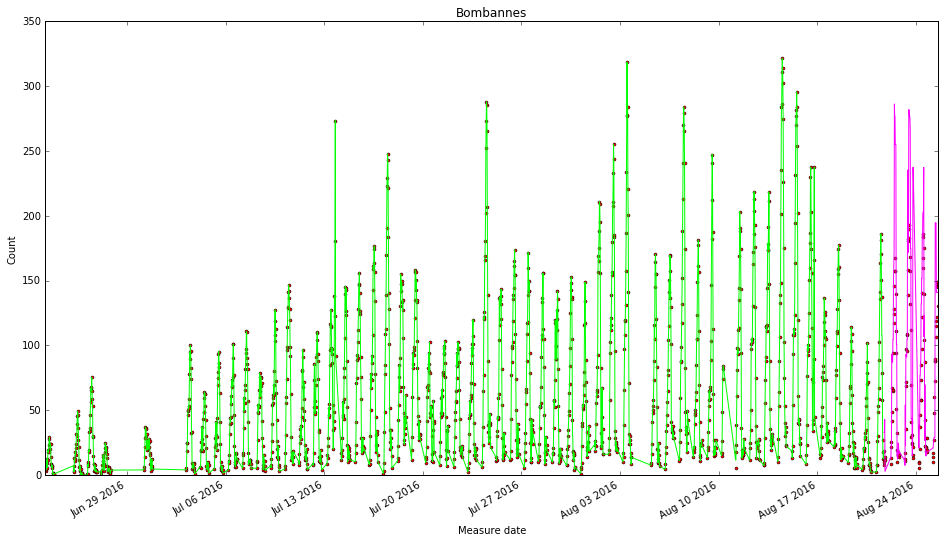

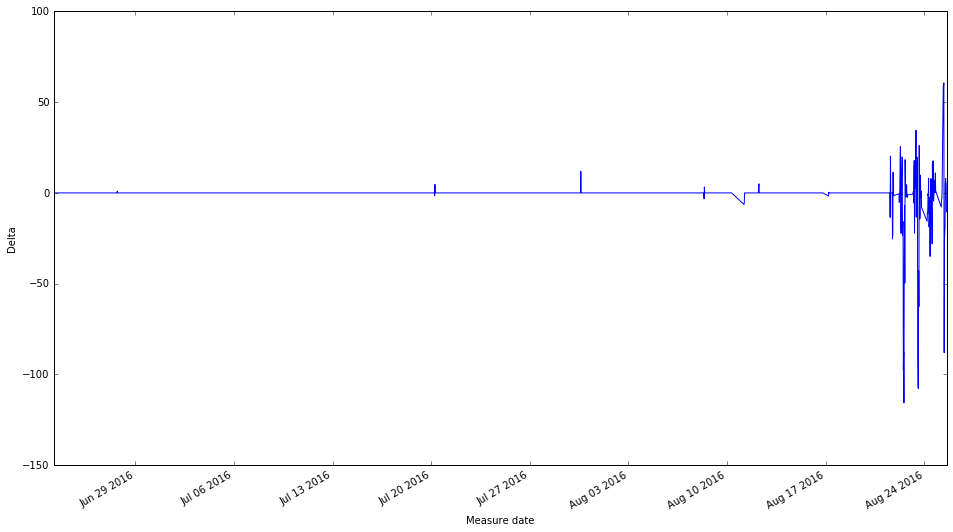

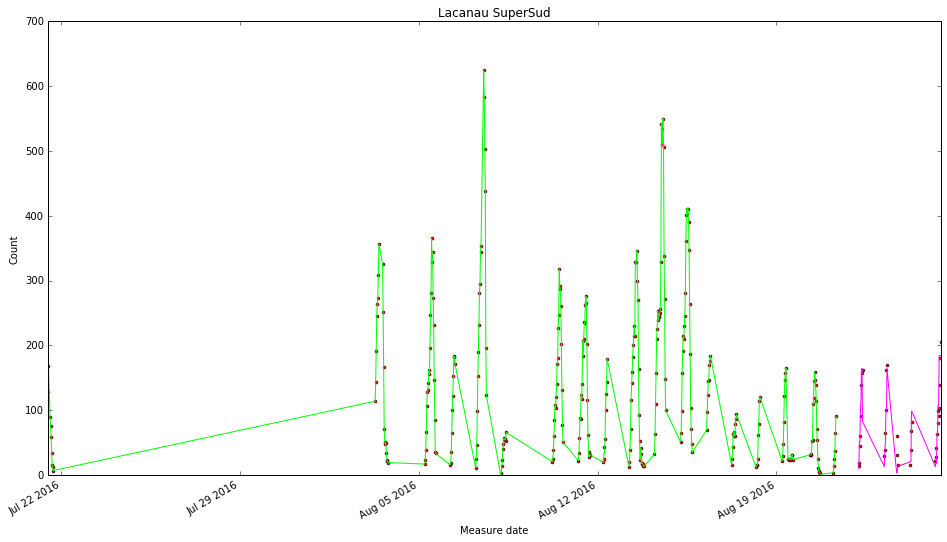

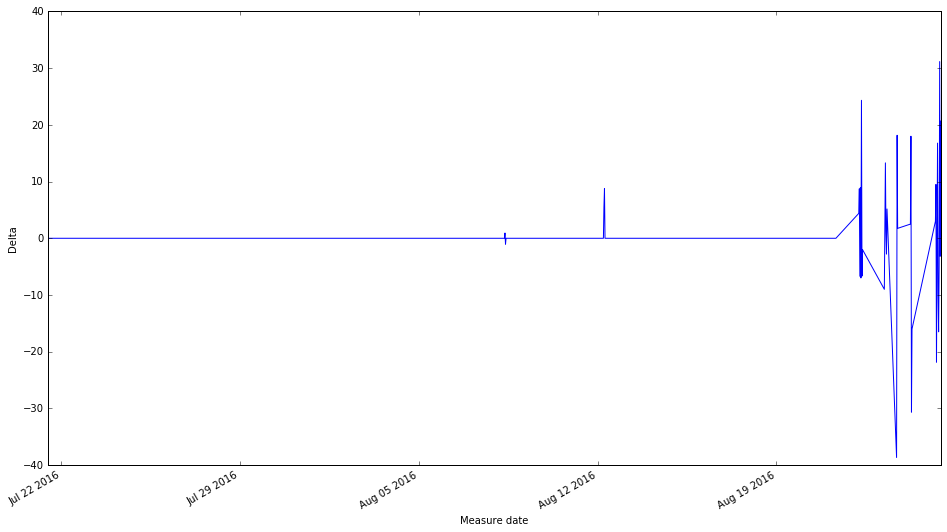

In [254]:
for place in places:
    cur = place["sensor_ids"][0]

    if cur:
        a = learned[X["id"] == cur]
        b = predicted[future_X["id"] == cur]

        m1 = Y[X["id"] == cur]
        m2 = future_Y[future_X["id"] == cur]
        
        m1.plot(style ='ro', ms=3)
        m2.plot(style = 'ro', ms=3)
        a.plot(c = "#00ff00")
        b.plot(c = "#FF00ff")

        #plt.legend([measures1, aa, bb], ["Measured", "Predicted", "Learned"], loc = "best")
        plt.xlabel("Measure date")
        plt.ylabel("Count")
        plt.title(place["name"])
        plt.figure()
        
        delta1 = m1[:]
        for index, row in enumerate(delta1):
            nb = delta1[index]
            array = []
            min = 1000
            for i in range(-2, 2):
                try:
                    new = nb - a[index + i]
                    if (new * new) < (min * min):
                        min = new
                except:
                    pass
            delta1[index] = min
        
        delta2 = m2[:]
        for index, row in enumerate(delta2):
            nb = delta2[index]
            array = []
            min = 1000
            for i in range(-2, 2):
                try:
                    new = nb - b[index + i]
                    if (new * new) < (min * min):
                        min = new
                except:
                    pass
            delta2[index] = min
        
        delta = delta1.append(delta2)
        delta.plot()
        plt.xlabel("Measure date")
        plt.ylabel("Delta")
        plt.figure()
plt.show()

# Prediction

Here you'll have the prediction up to an hour in the future for the sensor given in `sensor_id`.

In [203]:
sensor_id = '1'

In [204]:
from __future__ import division

weather_forecast = json_from_file('../data/weather_forecast.json')
weather_temperatures = weather_forecast["hourly"]["data"]

def totimestamp(dt, epoch=datetime.datetime(1970,1,1)):
    td = dt - epoch
    # return td.total_seconds()
    return int(((td.seconds + td.days * 86400) * 10**6) / 10**6) + 3600

def retrieve_measure(date):
    val = totimestamp(date.replace(tzinfo = None))
    for i in weather_temperatures:
        if i["time"] == val:
            return i

date_from = dateutil.parser.parse(by_sensor[sensor_id].iloc[len(by_sensor[sensor_id]) - 1].name)

day_of_week = week_day[date_from.strftime("%a")]
hour_of_day = date_from.hour + 1
temperature = retrieve_measure(date_from)["temperature"]

print "Date: " + str(date_from + datetime.timedelta(hours = 1))

for place in places:
    sensor_id = str(place['id'])
    
    try:
        previous    = by_sensor[sensor_id].iloc[len(by_sensor[sensor_id]) - 1]
    except:
        continue
    res = int(clf.predict([[
                    previous,
                    day_of_week,
                    hour_of_day,
                    temperature,
                    sensor_id
                ]])[0])

    print "  Expected: " + str(res) + " persons at " + place['name']

#print json.dumps(weather_temperature, indent=4, sort_keys=True)

NameError: name 'by_sensor' is not defined